In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import scipy as sp
import requests

In [2]:
data = pd.read_parquet(Path("data") / "train.parquet")

In [3]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [4]:
df_weather = pd.read_csv("external_data.csv")
df_weather['date'] = pd.to_datetime(df_weather.date)
df_weather.drop(df_weather.columns[0], axis=1, inplace=True)
df_weather.head()

,date,Temperature (C),wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1,sunshine_time,suntime,new_cases,holidays2
0,2020-09-01 23:00:00,14.9,NNE,5.6,63,20.0,0,1019.1,21960,48255,5104,0
1,2020-09-01 22:00:00,15.2,NNE,5.6,59,20.0,0,1019.0,21960,48255,5104,0
2,2020-09-01 21:00:00,16.4,NE,7.4,52,20.0,0,1018.9,21960,48255,5104,0
3,2020-09-01 20:00:00,17.1,NNE,7.4,49,20.0,0,1018.5,21960,48255,5104,0
4,2020-09-01 19:00:00,18.5,NNE,5.6,46,20.0,0,1017.9,21960,48255,5104,0


In [5]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [6]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
date_encoder.fit_transform(data[["date"]]).head()

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


In [7]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

enc.fit_transform(_encode_dates(data[["date"]])[["hour"]].head())

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [8]:
#COPY THIS CELL
X_train_comb = X_train.join(df_weather.set_index("date"), on="date") 
print(X_train_comb.shape)
X_train_comb["y_train"] = y_train.copy()
X_train_comb.dropna(inplace=True)
print(X_train_comb.shape)

y_train = X_train_comb["y_train"]
X_train_comb.drop("y_train", axis=1, inplace=True)

#Do the same operations for X_test
X_test_comb = X_test.join(df_weather.set_index("date"), on="date") 
print(X_test_comb.shape)
X_test_comb["y_test"] = y_test.copy()
X_test_comb.dropna(inplace=True)
print(X_test_comb.shape)

y_test = X_test_comb["y_test"]
X_test_comb.drop("y_test", axis=1, inplace=True)
X_test_comb.shape, y_test.shape

(455163, 21)
(448861, 22)
(41608, 21)
(41384, 22)


((41384, 21), (41384,))

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        #("scaler", scaler, numerical_cols)
    ]
)

regressor = Ridge()

pipe0 = make_pipeline(date_encoder, preprocessor, regressor)
pipe0.fit(X_train_comb, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000002C22CEBD630>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wind_dir'])])),
                ('ridge', Ridge())])

In [10]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe0.predict(X_train_comb), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe0.predict(X_test_comb), squared=False):.2f}"
)

Train set, RMSE=0.80
Test set, RMSE=0.72


In [11]:
from sklearn.metrics import r2_score

print(
    f"Train set, R^2={r2_score(y_train, pipe0.predict(X_train_comb)):.2f}"
)
print(
    f"Test set, R^2={r2_score(y_test, pipe0.predict(X_test_comb)):.2f}"
)

Train set, R^2=0.77
Test set, R^2=0.75


In [12]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

numerical_cols = X_train_comb.select_dtypes(include=np.number).columns
print(numerical_cols)
X_train_comb.head()

Index(['site_id', 'latitude', 'longitude', 'Temperature (C)', 'wind_speed',
       'Humidity', 'Visibility', 'Precipitation', 'pressure1', 'sunshine_time',
       'suntime', 'new_cases', 'holidays2'],
      dtype='object')


,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,...,wind_dir,wind_speed,Humidity,Visibility,Precipitation,pressure1,sunshine_time,suntime,new_cases,holidays2
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,NNO,1.9,77.0,20.0,0.0,1020.1,21960.0,48255.0,5104.0,0.0
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,NNO,1.9,77.0,20.0,0.0,1020.1,21960.0,48255.0,5104.0,0.0
87516,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,...,NNO,1.9,77.0,20.0,0.0,1020.1,21960.0,48255.0,5104.0,0.0
98518,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,...,NNO,1.9,77.0,20.0,0.0,1020.1,21960.0,48255.0,5104.0,0.0
875137,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,2020-09-01 01:00:00,2020-07-22,"48.88529,2.32666",Y2H20073268,48.885290,2.326660,...,NNO,1.9,77.0,20.0,0.0,1020.1,21960.0,48255.0,5104.0,0.0


In [13]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("scaler", scaler, numerical_cols)
    ]
)
params = {'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None,
              'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1.0,
              'early_stopping_rounds': None, 'enable_categorical': False, 'eta': 0.3,
              'eval_metric': 'rmse', 'feature_types': None, 'gamma': 0.3, 'gpu_id': -1,
              'grow_policy': 'depthwise', 'importance_type': None,
              'learning_rate': 0.2500000012, 'max_bin': 286,
              'max_cat_threshold': 64, 'max_cat_to_onehot': 4, 'max_delta_step': 0,
              'max_depth': 10, 'max_leaves': 0, 'min_child_weight': 4,
              'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 0,
              'num_parallel_tree': 1, 'predictor': 'auto',  'tree_method': 'gpu_hist'}

Boost = XGBRegressor(**params)

pipe2 =make_pipeline(date_encoder, preprocessor, Boost)
pipe2.fit(X_train_comb, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001BF6434A200>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wind_dir']),
                                                 ('scaler', St...
                              eval_metric='rmse', feature_types=None, gamma=0.3,
                              gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.2500000012, max_bin=286,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=10, max_leaves=0,
                              min_child_weight=4, missing=nan,
                              monotone_constraints='()', n_estimators=1500,
                              n_jobs=0, num_parallel_tree=1, predictor='auto', ...))])

In [14]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe2.predict(X_train_comb), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe2.predict(X_test_comb), squared=False):.2f}"
)

Train set, RMSE=0.34
Test set, RMSE=0.47


In [15]:
from sklearn.metrics import r2_score

print(
    f"Train set, R^2={r2_score(y_train, pipe2.predict(X_train_comb)):.2f}"
)
print(
    f"Test set, R^2={r2_score(y_test, pipe2.predict(X_test_comb)):.2f}"
)

Train set, R^2=0.96
Test set, R^2=0.89


In [16]:
mask = (
    (X_test_comb["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test_comb["date"] > pd.to_datetime("2021/09/01"))
    & (X_test_comb["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test_comb.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe2.predict(X_test_comb[mask])) - 1

Text(0, 0.5, 'bike_count')

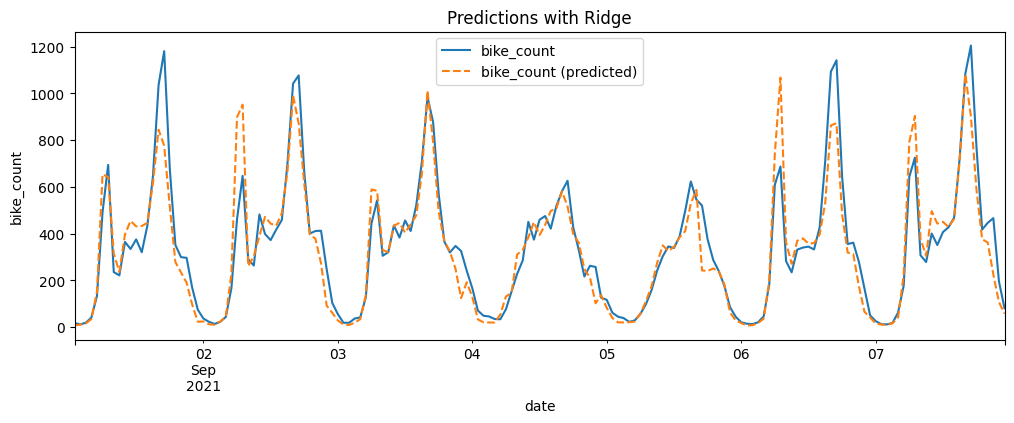

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count") 

## _LightGBM Regressor_

In [22]:
from lightgbm import LGBMRegressor

In [23]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("scaler", scaler, numerical_cols)
    ]
)
param_grid = {'learning_rate:':(.01,.02,.001,.1,.00002),
               'n_estimators':range(400,1300,150),
               'max_depth': range(10,40,4),'device':['gpu']}

Boost = LGBMRegressor()

pipe3 =make_pipeline(date_encoder, preprocessor, RandomizedSearchCV(estimator = Boost, param_distributions = param_grid,n_iter=150,
                                                                    cv = 6, verbose=10, random_state=42, n_jobs = 6))
pipe3.fit(X_train_comb, y_train)

Fitting 6 folds for each of 150 candidates, totalling 900 fits


exception calling callback for <Future at 0x26eb1ab9ba0 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\Rehan Ibrahim\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "c:\Users\Rehan Ibrahim\AppData\Local\Programs\Python\Python310\lib\multiprocessing\queues.py", line 122, in get
    return _ForkingPickler.loads(res)
ModuleNotFoundError: No module named 'lightgbm'
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\Rehan Ibrahim\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "c:\Users\Rehan Ibrahim\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\p

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
BestLGBM = pipe3[2].best_estimator
Params_LGBM = BestLGBM.set_params()

LGBMRegressor(learning_rate:=0.1, max_depth=34, n_estimators=480)

In [ ]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe3.predict(X_train_comb), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe3.predict(X_test_comb), squared=False):.2f}"
)

Train set, RMSE=0.45
Test set, RMSE=0.50


In [ ]:
from sklearn.metrics import r2_score

print(
    f"Train set, R^2={r2_score(y_train, pipe3.predict(X_train_comb)):.2f}"
)
print(
    f"Test set, R^2={r2_score(y_test, pipe3.predict(X_test_comb)):.2f}"
)

Train set, R^2=0.93
Test set, R^2=0.88


In [ ]:
mask = (
    (X_test_comb["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test_comb["date"] > pd.to_datetime("2021/09/01"))
    & (X_test_comb["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test_comb.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe3.predict(X_test_comb[mask])) - 1

Text(0, 0.5, 'bike_count')

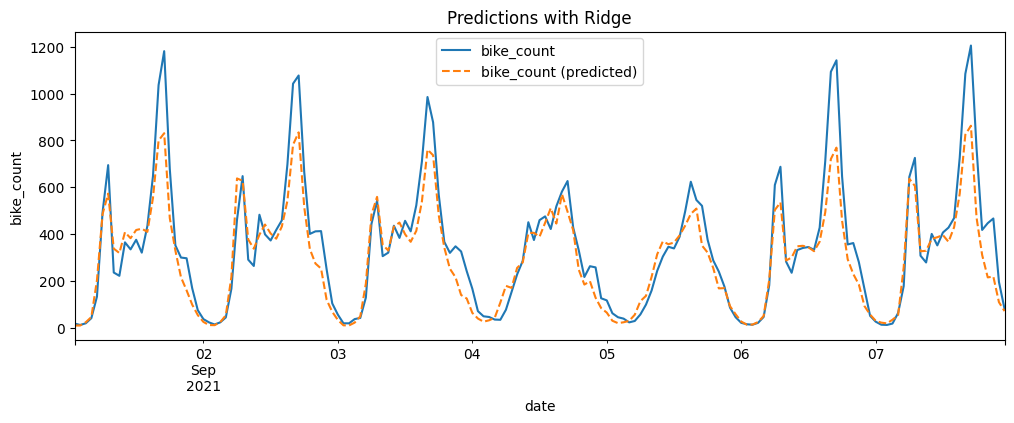

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count") 

## _CATBoost Regressor_

In [10]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

In [60]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("scaler", scaler, numerical_cols)
    ]
)


params ={'learning_rate': 0.14,
         'max_depth': 12, 'iterations': 900, 'task_type': 'GPU','l2_leaf_reg': 20,
         'bagging_temperature': 1, 'random_strength': 5, 'max_bin': 254}

Boost = CatBoostRegressor(**params)

pipe7 = make_pipeline(date_encoder, preprocessor, Boost)

pipe7.fit(X_train_comb, y_train)

0:	learn: 1.5220070	total: 34.6ms	remaining: 31.1s
1:	learn: 1.4025188	total: 70.2ms	remaining: 31.5s
2:	learn: 1.3012653	total: 106ms	remaining: 31.8s
3:	learn: 1.2196588	total: 140ms	remaining: 31.3s
4:	learn: 1.1541058	total: 169ms	remaining: 30.3s
5:	learn: 1.1015367	total: 199ms	remaining: 29.7s
6:	learn: 1.0608544	total: 232ms	remaining: 29.6s
7:	learn: 1.0229357	total: 266ms	remaining: 29.6s
8:	learn: 0.9889059	total: 298ms	remaining: 29.5s
9:	learn: 0.9564994	total: 334ms	remaining: 29.7s
10:	learn: 0.9331585	total: 366ms	remaining: 29.6s
11:	learn: 0.9121557	total: 396ms	remaining: 29.3s
12:	learn: 0.8871164	total: 430ms	remaining: 29.4s
13:	learn: 0.8626637	total: 462ms	remaining: 29.3s
14:	learn: 0.8473658	total: 493ms	remaining: 29.1s
15:	learn: 0.8297072	total: 526ms	remaining: 29.1s
16:	learn: 0.8111402	total: 561ms	remaining: 29.1s
17:	learn: 0.7978705	total: 592ms	remaining: 29s
18:	learn: 0.7855949	total: 624ms	remaining: 28.9s
19:	learn: 0.7715616	total: 657ms	remaini

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000002C22CEBD630>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wind_dir']),
                                                 ('scaler', StandardScaler(),
                                                  Index(['site_id', 'latitude', 'longitude', 'Temperature (C)', 'wind_speed',
       'Humidity', 'Visibility', 'Precipitation', 'pressure1', 'sunshine_time',
       'suntime', 'new_cases', 'holidays2'],
      dtype='object'))])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x000002C204FD9420>)])

In [ ]:
BestCGB = pipeC[2].best_estimator
Params_CGB = BestCGB.set_params()

In [2]:
pd.DataFrame(pipeC[2].cv_results_)

NameError: name 'pd' is not defined

In [61]:
from sklearn.metrics import r2_score

print(
    f"Train set, R^2={r2_score(y_train, pipe7.predict(X_train_comb)):.5f}"
)
print(
    f"Test set, R^2={r2_score(y_test, pipe7.predict(X_test_comb)):.5f}"
)

Train set, R^2=0.96251
Test set, R^2=0.89821


In [62]:
from sklearn.metrics import mean_squared_error
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe7.predict(X_train_comb), squared=False):.5f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe7.predict(X_test_comb), squared=False):.5f}"
)

Train set, RMSE=0.32442
Test set, RMSE=0.45922


In [ ]:
mask = (
    (X_test_comb["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test_comb["date"] > pd.to_datetime("2021/09/01"))
    & (X_test_comb["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test_comb.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipeC.predict(X_test_comb[mask])) - 1

Text(0, 0.5, 'bike_count')

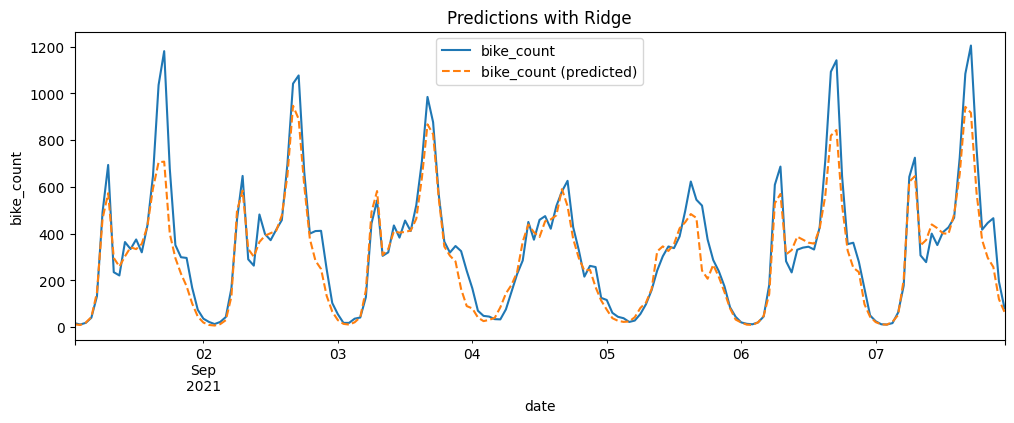

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count") 

In [4]:
import joblib
joblib.dump(pipe3, 'CatBoost')
joblib.dump(pipe3[2].best_estimator_, 'CatBoost Best Model')

NameError: name 'pipe3' is not defined

## _Random Forest Regressor with GridSearchCV_

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("scaler", scaler, numerical_cols)
    ]
)

RandomForest = RandomForestRegressor(bootstrap=True,oob_score=True)

param_grid = {'max_depth': np.arange(1, 15),
              'n_estimators': np.arange(1, 100, 15),
              'max_features':(.4,.2),
              'min_samples_leaf':(30,20),
              }

pipe4 = make_pipeline(
    date_encoder,
    preprocessor,
    GridSearchCV(RandomForest,
                 param_grid,
                 n_jobs=-1,
                 cv=3)
)
pipe4.fit(X_train_comb, y_train)

In [ ]:
BestFR = pipe4[2].best_estimator
Params_FR = BestFR.set_params()

In [ ]:
from sklearn.metrics import r2_score

print(
    f"Train set, R^2={r2_score(y_train, pipe4.predict(X_train_comb)):.2f}"
)
print(
    f"Test set, R^2={r2_score(y_test, pipe4.predict(X_test_comb)):.2f}"
)

NameError: name 'pipe4' is not defined

In [ ]:
df_result = pd.DataFrame(pipe4[-1].cv_results_)
display(df_result)

In [ ]:
mask = (
    (X_test_comb["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test_comb["date"] > pd.to_datetime("2021/09/01"))
    & (X_test_comb["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test_comb.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe4.predict(X_test_comb[mask])) - 1

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")